# CAS Machine Intelligence
# Module Advanced Big Data Topics
### Proof of Perfomance
##### Winterthur, 17.01.2023
<p>
<h2>Title: Sentiment Analysis on Twitter for Bitcoin Trading</h2>
</p>
<P><h4>Professor: </h4>
Pavel Sulimov
</p>
<p><h4>Students: </h4>
Sven Goldinger </br>
Furio Valerio Sordini
</p>

In [3]:
!python --version

Python 3.9.0


In [4]:
#IMPORTANT: Install tweepy directly from github to get latest and greatest version 4.12 (instead of 3.10)
# !pip install git+https://github.com/tweepy/tweepy.git

In [2]:
import json
import tweepy 
import time
import pandas as pd
import numpy as np
import datetime
import requests
import regex as re
import random
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
rs = 7 # random state

import matplotlib.pyplot as plt

In [3]:
wnl = WordNetLemmatizer()

# 1. Streaming Bitcoin quotes

This code is copied from https://github.com/josiemundi/python-bitcoin-stream/blob/master/get_bitcion_value.ipynb, the credit goes to 
josiemundi.
The script posts a request to the coinbase API and gets the latest quote of bitcoin in USD, EUR and GBP.</br>
We added to the script a new method to store the data in a pd dataframe after each update.

In [4]:
class PriceChecker():
    
    def __init__(self,url,freq=60):
        self.url = url
        self.freq = freq
        self.lastupdate = None
        self.prices = {}
        self.register = pd.DataFrame(columns=("Time", "PriceUSD"))
        self.update_price()

        
    def update_price(self):
        print("updating prices")
        r = requests.get(self.url)
        self.lastupdate = datetime.datetime.now()
        price_result = r.json()
        self.price_timestamp = datetime.datetime.strptime(price_result["time"]["updatedISO"][:-6],'%Y-%m-%dT%H:%M:%S')        
        for symbol in ['USD','GBP','EUR']:
            self.prices[symbol] = price_result['bpi'][symbol]['rate_float']
        self.update_df()
    
    def update_df(self):
        new_df = pd.DataFrame([[self.lastupdate, self.price['USD']]], columns=("Time","PriceUSD"))
        self.register = pd.concat([self.register, new_df], ignore_index=True)
        return
            
    @property
    def price(self):
        if (datetime.datetime.now()-self.lastupdate).total_seconds() >= self.freq:
            self.update_price()
        return self.prices


In [5]:
my_url = "https://api.coindesk.com/v1/bpi/currentprice.json"
my_price_checker = PriceChecker(url=my_url)
my_price_checker.update_price()
print("The last update happend on {}".format(my_price_checker.lastupdate))
print("Latest bitcoin price in USD: {}".format(my_price_checker.price['USD']))

updating prices
updating prices
The last update happend on 2023-01-17 09:38:08.950300
Latest bitcoin price in USD: 21189.3075


In [12]:
my_price_checker.update_price()
my_price_checker.register

updating prices


,Time,PriceUSD
0,2023-01-17 09:38:08.886655,21189.3075
1,2023-01-17 09:38:08.950300,21189.3075
2,2023-01-17 09:38:09.133250,21189.3075
3,2023-01-17 09:38:13.519624,21189.3075
4,2023-01-17 09:38:14.288676,21189.3075
5,2023-01-17 09:38:14.927399,21189.3075
6,2023-01-17 09:38:15.502900,21189.3075
7,2023-01-17 09:38:16.229556,21189.3075
8,2023-01-17 09:38:18.939796,21189.3075


# 2. Model for Sentiment Analysis
The LSTM model is trained on this dataset made available by kaggle: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis</br>
Before training the model, the tweets have been cleaned and preprocessed

In [13]:
human_labels_path = r"data.csv"
hl = pd.read_csv(human_labels_path)

## 2.1 Text Pre-processing

In [14]:
def wordnet_lemmatize_text(text):
  # tokenize text
  tokens = nltk.word_tokenize(text)
  # pos tag tokenized text
  tagged_tokens = nltk.pos_tag(tokens)
  # convert raw POS tags into wordnet tags
  tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
  # treat unknown tags as nouns by default
  new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), 
                                          wordnet.NOUN))
                            for word, tag in tagged_tokens]

  lemmatized_text = ' '.join(wnl.lemmatize(word, tag) for word, tag in new_tagged_tokens)
  return lemmatized_text

hl['Sent_Lemm'] = hl.Sentence.apply(lambda x: wordnet_lemmatize_text(x))

In [15]:
def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

hl['Stop_Words'] = hl.Sent_Lemm.apply(lambda x: remove_stopwords(x))

In [16]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

hl['CleanSentence'] = hl.Stop_Words.apply(lambda x: remove_special_characters(x))

## 2.2 Test Train Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(hl['CleanSentence'], hl['Sentiment'], test_size=0.15, random_state=rs, shuffle=True)

## 2.3 Pre-Process Data

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
# Download the embeddings and vocab file here: https://drive.switch.ch/index.php/s/rNmy0yKDDkRAmcq
word_embeddings = np.load('wiki.multi.en.vec_data.npy')
vocab = json.load(open('wiki.multi.en.vec_vocab.json'))

In [20]:
def tokenize(texts: list[str]) -> list[list[str]]:
    return [re.findall(r'\w+', text.lower()) for text in texts]

train_tokens = tokenize(X_train.tolist())
ohe = OneHotEncoder(sparse=False)  # One-hot encode string labels
train_labels = ohe.fit_transform([[label] for label in y_train.tolist()])
test_labels = ohe.fit_transform([[label] for label in y_test.tolist()])

In [21]:
# Only use needed word embeddings, do this to save RAM
# Build vocab on training data
train_vocab = {'PAD': 0}  # special padding symbol
selected_word_embeddings = [np.zeros(word_embeddings.shape[1])]  # zero vector for PAD symbol
for tokens in train_tokens:
    for token in tokens:
        if not token in train_vocab:
            if token in vocab:
                train_vocab[token] = max(train_vocab.values()) + 1
                selected_word_embeddings.append(word_embeddings[vocab[token]])

selected_word_embeddings = np.array(selected_word_embeddings)
del word_embeddings

In [22]:
maxlen = max(len(tokens) for tokens in train_tokens)

from this point not necessary to run

In [16]:
def tok2int(tokens_list: list, vocab: dict) -> list[list[int]]:
    """Replaces tokens with their assigned IDs"""
    token_ints = list()
    for tokens in tokens_list:
        token_ints.append([vocab[tok] for tok in tokens if tok in vocab])
    return token_ints

In [17]:
train_ints = tok2int(train_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
train_ints_padded = tf.keras.utils.pad_sequences(train_ints, maxlen=maxlen)

## 2.4 Define and Train Model

In [18]:
# Define the model: Try changing the layers and their sizes
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(train_vocab), # Number of tokens in the dicitonary
                                    mask_zero=True,  # ignore padding symbol
                                    input_length=maxlen,  # max text length
                                    embeddings_initializer=tf.keras.initializers.Constant(selected_word_embeddings),  # initialize the embeddings with the pretrained ones
                                    trainable=False,  # we're not updating the pre-trained word embeddings
                                    output_dim=300)  # dimensions of the word embeddings
         )
# model.add(tf.keras.layers.GlobalAveragePooling1D())  # Average the word embeddings
model.add(tf.keras.layers.LSTM(128))  # LSTM instead of average pooling
model.add(tf.keras.layers.Dense(512, activation='relu'))  # "Hidden" layer
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Final classification layer
model.compile(optimizer='adam', loss='CategoricalCrossentropy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 300)           1945200   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2,232,435
Trainable params: 287,235
Non-trainable params: 1,945,200
_________________________________________________________________
None


In [19]:
# Train
model.fit(train_ints_padded, train_labels, epochs=20, verbose=1, validation_split=0.1, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ])

Epoch 1/20
140/140 [==============================] - 11s 52ms/step - loss: 0.9118 - val_loss: 0.7698
Epoch 2/20
140/140 [==============================] - 6s 45ms/step - loss: 0.7710 - val_loss: 0.6919
Epoch 3/20
140/140 [==============================] - 5s 39ms/step - loss: 0.6806 - val_loss: 0.6383
Epoch 4/20
140/140 [==============================] - 5s 37ms/step - loss: 0.6266 - val_loss: 0.6237
Epoch 5/20
140/140 [==============================] - 7s 53ms/step - loss: 0.6024 - val_loss: 0.6530
Epoch 6/20
140/140 [==============================] - 16s 111ms/step - loss: 0.5529 - val_loss: 0.6806
Epoch 7/20
140/140 [==============================] - 16s 113ms/step - loss: 0.5157 - val_loss: 0.7010


In [20]:
# Predict & Evaluate
test_tokens = tokenize(X_test.tolist())
test_ints = tok2int(test_tokens, train_vocab)
# Make all texts the same length, pad with zeroes
test_ints_padded = tf.keras.utils.pad_sequences(test_ints, maxlen=maxlen)
predicted_labels_pretrained_int = model.predict(test_ints_padded)
predicted_labels_pretrained = ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
print(classification_report(y_test, predicted_labels_pretrained))

28/28 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

    negative       0.43      0.31      0.36       138
     neutral       0.76      0.80      0.78       476
    positive       0.67      0.69      0.68       263

    accuracy                           0.69       877
   macro avg       0.62      0.60      0.61       877
weighted avg       0.68      0.69      0.68       877



In [25]:
model.save('/Models/')

INFO:tensorflow:Assets written to: /Models/assets


INFO:tensorflow:Assets written to: /Models/assets


# 3. Preparing the stream from the twitter API

In [23]:
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAB9zjwEAAAAArXsEeUSAHw1XZnq7hHU4V5aurzQ%3DNzy8VYlgiDV2WiFqfQuTQKu5kcEwoUxZZ2Bl6R4Qvip3gePBL4"

In [24]:
TWITTER_APP_KEY = "o8tkbrHsLL0OOlBlKTXAfVAMu"
TWITTER_APP_SECRET = "eADJRcpOaDmO7jXYyTVDvQQfPb2FjWc0isUlcDCNczPQdQ9ZWP"
TWITTER_KEY = "1597527989847212033-xCRwApuIQXpEcabnKfkEbzLaPM8jgH"
TWITTER_SECRET = "L5Janz1QZsva1iXM1Yg2LiMzx5lUnWDaNAPW1Gf62ZJb8"

## 3.1 Load Classifier
The model is a LSTM classifier trained on around 5'000 tweets on bitcoin. The model predict positive, neutral and negative sentiment given a tweet.

In [25]:
model = keras.models.load_model('/Models/')

# 4. Create Listener
This class is based on tweepy, and aims to collect real time tweets, lemmatize the test, then clean it from stop word and special characters. 
In a second moment the text is pre-processed to predict the sentiment. The tweet, the time stample, the tweet id, the cleaned sentence are saved in a pandas dataframe. 

In [26]:
class myStreamingClient(tweepy.StreamingClient):

    df = pd.DataFrame(columns=("id", "Sentence", "Time", "CleanedSentence", "Sentiment", "BitcoinPrice"))
    # DEBUG
    reduced_df = pd.DataFrame(columns=("id", "Sentence", "Time"))
    train_vocab = dict
    maxlen = int
    ohe = OneHotEncoder(sparse=False)
    model = keras.models.load_model('/Models/')
    # Bitcoin Price Checker
    bitcoinPrice = PriceChecker("https://api.coindesk.com/v1/bpi/currentprice.json")
    
    def addTrainVoc(self, train_vocab):
        self.train_vocab = train_vocab
        return
    
    def addMaxLen(self, maxlen):
        self.maxlen = maxlen


    def on_tweet(self, tweet):
        id = tweet.id
        sentence = tweet.text
        time = datetime.datetime.now()
        tw = tweet
        # DEBUG
        # cleanedTweet = self.cleanSentence(tw)
        # preProcessedTweet = self.preprocess(cleanedTweet)
        # SentimentPrediction = self.predictSentiment(preProcessedTweet)
        # new_df = self.to_pd(id, sentence, time, cleanedTweet, preProcessedTweet, SentimentPrediction)
        # DEBUG
        new_df = self.to_reduced_pd(id, sentence, time)
        self.reduced_df = pd.concat([new_df, self.reduced_df], ignore_index=True)
        # print(self.reduced_df.head())
        
        new_df_compl = self.cleanSentence(new_df)
        cleanedTweet = new_df.loc[0, 'CleanedSentence']
        preProcessedTweet = self.preprocess(cleanedTweet)
        # new_df_compl['PreProcessedSentence'] = preProcessedTweet
        SentimentPrediction = self.predictSentiment(preProcessedTweet)
        new_df_compl['Sentiment'] = SentimentPrediction
        self.bitcoinPrice.update_price()
        new_df_compl['BitcoinPrice'] = self.bitcoinPrice.price['USD']
        self.df = pd.concat([new_df_compl, self.df.loc[:]], ignore_index=True)
        print(self.df.head())
        
    ###################
    #                 #
    # DATA FORMATTING #
    #                 #
    ###################

    def to_pd(self, id, sentence, time, cleanedSentence, PreProcessedSentence, Sentiment):
        return pd.DataFrame([[id, sentence, time, cleanedSentence, PreProcessedSentence, Sentiment]], 
                        columns=("id", "Sentence", "Time", "CleanedSentence", "Sentiment", "BitcoinPrice"))
    
    # DEBUG
    def to_reduced_pd(self, id, sentence, time):
        return pd.DataFrame([[id, sentence, time]], 
                        columns=("id", "Sentence", "Time"))

    
    def tweet_to_dic(self, id, sentence, time, cleanedSentence, PreProcessedSentence, Sentiment):
        dic = {"id": id, "Sentence": sentence, "Time":time, "cleanedSentence":cleanedSentence, 
        "Sentiment":Sentiment}
        return(dic)
    
    #################
    #               #
    # CLEANING TEXT #
    #               #
    #################

    # def cleanSentence(self, sentece):
    #     lemmatizedSentence = self.wordnet_lemmatize_text(sentece)
    #     stopWordSentence = self.remove_stopwords(lemmatizedSentence)
    #     cleanedSentence = self.remove_special_characters(stopWordSentence)
    #     return cleanedSentence

    def cleanSentence(self, dataframe):
        dataframe['CleanedSentence'] = dataframe.Sentence.apply(lambda x: self.wordnet_lemmatize_text(x))
        dataframe['CleanedSentence'] = dataframe.CleanedSentence.apply(lambda x: self.remove_stopwords(x))
        dataframe['CleanedSentence'] = dataframe.CleanedSentence.apply(lambda x: self.remove_special_characters(x))
        return dataframe

    # LEMMATIZATION
    def wordnet_lemmatize_text(self, text):
        # tokenize text
        tokens = nltk.word_tokenize(text)
        # pos tag tokenized text
        tagged_tokens = nltk.pos_tag(tokens)
        # convert raw POS tags into wordnet tags
        tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
        # treat unknown tags as nouns by default
        new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), 
                                                wordnet.NOUN))
                                    for word, tag in tagged_tokens]

        lemmatized_text = ' '.join(wnl.lemmatize(word, tag) for word, tag in new_tagged_tokens)
        return lemmatized_text    
    
    # STOP WORD REMOVAL
    def remove_stopwords(self, text, is_lower_case=False, stopwords=None):
        if not stopwords:
            stopwords = nltk.corpus.stopwords.words('english')
        tokens = nltk.word_tokenize(text)
        tokens = [token.strip() for token in tokens]
        
        if is_lower_case:
            filtered_tokens = [token for token in tokens if token not in stopwords]
        else:
            filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
        
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text
    
    # SPECIAL CHARACTERS REMOVAL
    def remove_special_characters(self, text, remove_digits=False):
        pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
        text = re.sub(pattern, '', text)
        return text

    #######################
    #                     #
    # TEXT PRE PROCESSING #
    #                     #
    #######################

    def preprocess(self, text):
        text = [text]
        test_tokens = self.tokenize(text)
        test_ints = self.tok2int(test_tokens, self.train_vocab)
        # Make all texts the same length, pad with zeroes
        test_ints_padded = tf.keras.utils.pad_sequences(test_ints, maxlen=self.maxlen)
        return test_ints_padded

    def tokenize(self, texts: list[str]) -> list[list[str]]:
        return [re.findall(r'\w+', text.lower()) for text in texts]

    def tok2int(self, tokens_list: list, vocab: dict) -> list[list[int]]:
        """Replaces tokens with their assigned IDs"""
        token_ints = list()
        for tokens in tokens_list:
            token_ints.append([vocab[tok] for tok in tokens if tok in vocab])
        return token_ints

    ########################
    #                      #
    # SENTIMENT PREDICTION #
    #                      #
    ########################

    def predictSentiment(self, processedSentence):
        predictedLabels_ints = self.model.predict([processedSentence])
        predicted_labels_pretrained = self.ohe.inverse_transform(predictedLabels_ints)
        predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
        return predicted_labels_pretrained[0]

    #Error Handling
    def on_error(self, status_code):
        if status_code == 420: #Twitter API sends 420 if we are rate limited
            return False


updating prices


# 5. Streaming

## 5.1 Preparing Streamer class

In [27]:
twitterStream = myStreamingClient(BEARER_TOKEN)
twitterStream.get_rules()
twitterStream.add_rules(tweepy.StreamRule("Bitcoin"))

Response(data=None, includes={}, errors=[{'value': 'Bitcoin', 'id': '1612816466683781120', 'title': 'DuplicateRule', 'type': 'https://api.twitter.com/2/problems/duplicate-rules'}], meta={'sent': '2023-01-17T08:50:00.048Z', 'summary': {'created': 0, 'not_created': 1, 'valid': 0, 'invalid': 1}})

## 5.2 Adding parameters for sentiment prediction:
1. vocab dictionary 
2. sentence length parameters
3. one hot encoder

this part works only if part of the model sentiment analysis is executed and the variables train_vocab and maxlen are available!

In [28]:
twitterStream.addTrainVoc(train_vocab=train_vocab)
twitterStream.addMaxLen(maxlen=maxlen)
twitterStream.ohe.fit(([[label] for label in y_train.tolist()]))

OneHotEncoder(sparse=False)

## 5.3 Starting the stream

In [29]:
twitterStream.filter()

1/1 [==============================] - 2s 2s/step
updating prices
                    id                                  Sentence  \
0  1615270599277924355  @LayahHeilpern I love you @LayahHeilpern   

                        Time                     CleanedSentence Sentiment  \
0 2023-01-17 09:51:41.932662   LayahHeilpern love  LayahHeilpern  positive   

   BitcoinPrice  
0    21198.2197  
1/1 [==============================] - 0s 29ms/step
updating prices
                    id                                           Sentence  \
0  1615270602851643392  @swissborg Earn $500-$1000 daily trading altco...   
1  1615270599277924355           @LayahHeilpern I love you @LayahHeilpern   

                        Time  \
0 2023-01-17 09:51:43.664598   
1 2023-01-17 09:51:41.932662   

                                     CleanedSentence Sentiment  BitcoinPrice  
0   swissborg Earn  500  1000 daily trading altco...  positive    21198.2197  
1                  LayahHeilpern love  LayahHeilp

KeyboardInterrupt: 

# 6. Creating a trading indicator

In [30]:
twitterStream.df.head()

,id,Sentence,Time,CleanedSentence,Sentiment,BitcoinPrice
0,1615270869995032578,Yes https://t.co/PNyBsgnPCN,2023-01-17 09:52:48.887096,Yes http tcoPNyBsgnPCN,positive,21196.3531
1,1615270868120375297,@Crypto__Diva Next support level for $BTC is a...,2023-01-17 09:52:48.764767,Crypto__Diva Next support level BTC 20000 ...,negative,21196.3531
2,1615270873329541122,"@batirovic Yaxshi javob, lekin siz aytgan muom...",2023-01-17 09:52:48.631416,batirovic Yaxshi javob lekin siz aytgan muom...,neutral,21196.3531
3,1615270869861027844,RT @TheDustyBC: 💥#Bitcoin Scrotum Pattern!!! h...,2023-01-17 09:52:48.501020,RT TheDustyBC Bitcoin Scrotum Pattern h...,positive,21196.3531
4,1615270870578233344,@malak200a شكرا دكتوره ملوكه,2023-01-17 09:52:48.369609,malak200a,neutral,21196.3531


In [31]:
twitterStream.df.shape

(367, 6)

In [32]:
# Using the time stample as index
twitterStream.df.set_index('Time', inplace=True)

In [33]:
# Converting the sentiment prediction in numeric values
conversion = {"negative":-1, "neutral":0, "positive":1}
twitterStream.df['SentimentNumeric'] = twitterStream.df.Sentiment.map(conversion)

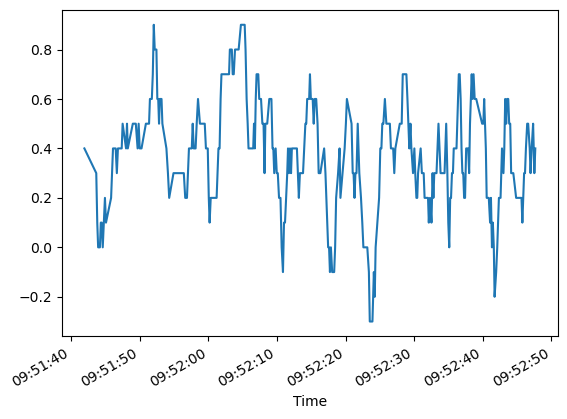

In [34]:
# Creating a rolling sentiment score
wind = 10
twitterStream.df['RollingSentiment'] = twitterStream.df.SentimentNumeric.rolling(window = wind).sum().div(wind)
twitterStream.df['RollingSentiment'].plot();

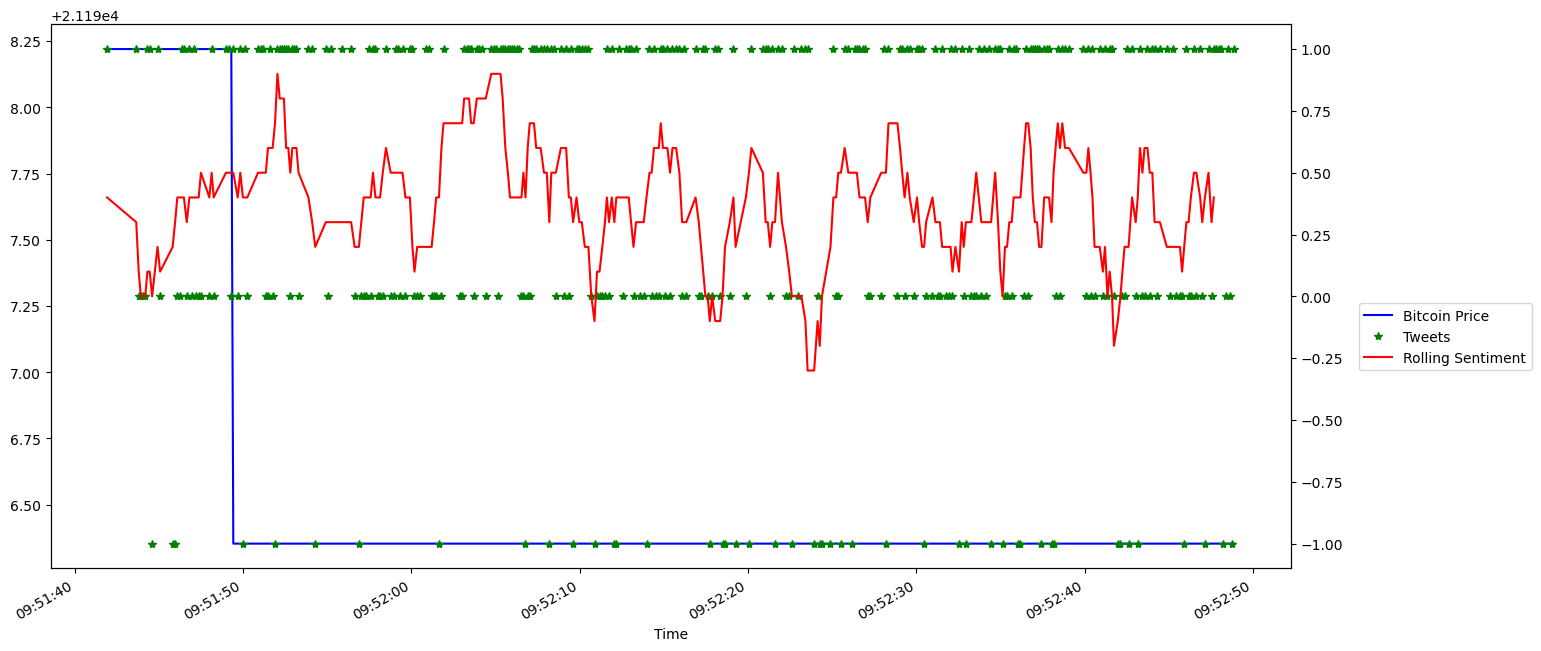

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))

twitterStream.df.BitcoinPrice.plot(ax=ax, style='b-')
# same ax as above since it's automatically added on the right
twitterStream.df.SentimentNumeric.plot(ax=ax, style='g*', secondary_y=True)
twitterStream.df.RollingSentiment.plot(ax=ax, style='r-', secondary_y=True)

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax.right_ax.get_lines()[1]],
['Bitcoin Price','Tweets', 'Rolling Sentiment'], bbox_to_anchor=(1.2, 0.5));

# 7. Trading Strategy
The high-frequency trading strategy is based on the rolling sentiment score and doesn't take into account bid/ask spread, trading costs and slippage.</br>
<b>Trading Frequency:</b> allocation updated after each request at the tweeter API</br>
<b>Strategy:</b> long short, depending on the sentiment score

In [37]:
def allocateCapital(score, threshold):
    allocation = 0
    if score > threshold:
        allocation = 1
    if score < - threshold:
        allocation = -1
    return allocation


In [38]:
def updatePortfolio(capitalT_1, quoteT_1, quoteT0, allocation):
    valueChange = (quoteT0 - quoteT_1) / quoteT_1
    capitalT0 = capitalT_1 * (1 + valueChange * allocation)
    return (capitalT0)

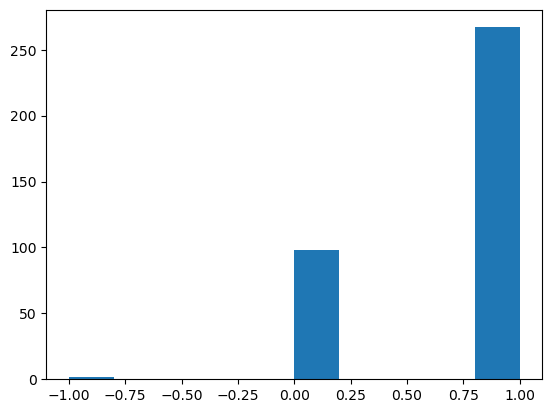

In [39]:
threshold = 0.2

trading = twitterStream.df
trading['Capital'] = 1
trading['Allocation'] = trading.apply(lambda x: allocateCapital(x['RollingSentiment'], threshold), axis=1)
trading['Allocation'].hist(grid=False);

In [40]:
for index, raw in trading.iterrows():
    numIndex = trading.index.get_loc(index)
    if numIndex > 0:
        allocation = trading.iloc[numIndex - 1, 8]     # allocation at time t-1, given prediction at time t-1
        capitalT_1 = trading.iloc[numIndex - 1, 7]     # capital at time t-1
        quoteT0 = raw.BitcoinPrice                     # price at time t0
        quoteT_1 = trading.iloc[numIndex - 1, 4]       # price at time t-1
        capital_T_1 = raw.Capital
        trading.iloc[numIndex, 7] = updatePortfolio(capitalT_1=capital_T_1, quoteT_1=quoteT_1, quoteT0=quoteT0, allocation=allocation)

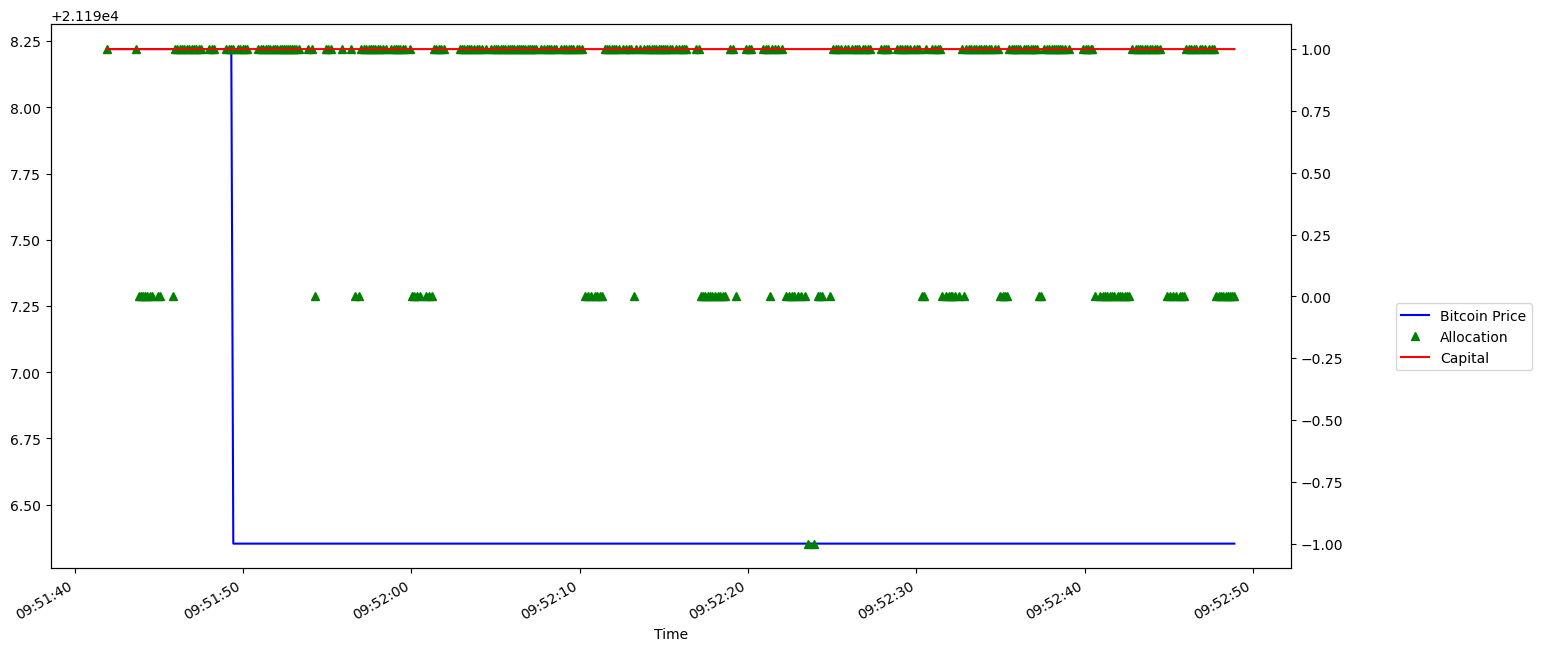

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))

trading.BitcoinPrice.plot(ax=ax, style='b-')
# same ax as above since it's automatically added on the right
trading.Allocation.plot(ax=ax, style='g^', secondary_y=True)
trading.Capital.plot(ax=ax, style='r-', secondary_y=True)

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax.right_ax.get_lines()[1]],
['Bitcoin Price','Allocation', 'Capital'], bbox_to_anchor=(1.2, 0.5));

# 8. Back-Testing the Trading Strategy
Given an exisiting database of tweets and historic bitcoin prices, the strategy can be test over longer period of time, avoiding the cold start problem given by the streaming method. The dataset can be downloaded from kaggle: https://www.kaggle.com/datasets/gautamchettiar/bitcoin-sentiment-analysis-twitter-data

In [109]:
tweets = pd.read_csv("bitcoin_tweets1000000.csv")
tweets.head()

c:\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3139: DtypeWarning: Columns (0,5,6,7,8,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,cleanText,Polarity Score,sentiment
0,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,blue ridge bank shares halted nyse bitcoin atm...,0.00,0.0
1,1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,today thursday take friend leowandersleb btc w...,0.00,0.0
2,2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,guys evening read article btc would like share,0.00,0.0
3,3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,btc big chance billion price bitcoin btc crypto,0.00,0.0
4,4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,network secured nodes today soon biggest bears...,-0.25,0.0


In [44]:
tweets.shape

(1000025, 17)

In [276]:
fakeStream = myStreamingClient(BEARER_TOKEN)
fakeStream.get_rules()
fakeStream.add_rules(tweepy.StreamRule("Bitcoin"))
fakeStream.addTrainVoc(train_vocab=train_vocab)
fakeStream.addMaxLen(maxlen=maxlen)
fakeStream.ohe.fit(([[label] for label in y_train.tolist()]))

OneHotEncoder(sparse=False)

pricking only n tweets, to avoid too long computations. Random picks random number in a range without repeatitions

In [277]:
tweetNumber = 50000
random.seed(7)
twIndices = random.sample(range(0, tweets.shape[0]), tweetNumber)

In [278]:
fakeStream.df = fakeStream.df[0:0]
fakeStream.df

,id,Sentence,Time,CleanedSentence,Sentiment,BitcoinPrice


In [279]:
fakeStream.df.Sentence = tweets.text[twIndices]
fakeStream.df.Time = pd.to_datetime(tweets.date[twIndices], errors='coerce')
fakeStream.df.CleanedSentence = tweets.cleanText[twIndices]

In [280]:
fakeStream.df = fakeStream.df.reset_index()
fakeStream.df

,index,id,Sentence,Time,CleanedSentence,Sentiment,BitcoinPrice
0,339563,NaN,"@BillyM2k #Bitcoin Traders are, optimistic, ex...",2021-07-02 14:45:06,billymk bitcoin traders optimistic expecting r...,NaN,NaN
1,993908,NaN,@TheLondonCrypto @MiniUSDC 💎💎GEM OF THE CENTUR...,2021-08-15 18:19:58,thelondoncrypto miniusdc gem century satstacke...,NaN,NaN
2,158176,NaN,"As cryptocurrency and blockchain evolves, the ...",2021-06-22 23:37:53,cryptocurrency blockchain evolves crypto gloss...,NaN,NaN
3,414002,NaN,https://t.co/2TF4C1lgoM Handbook of Digital Cu...,2021-07-23 03:31:01,handbook digital currency bitcoin innovation f...,NaN,NaN
4,682554,NaN,"$BTC breaking Low BB 1H window,just now. #BTC ...",2021-07-26 21:37:57,btc breaking low window btc bnb doge luna alts...,NaN,NaN
...,...,...,...,...,...,...,...
49995,677297,NaN,"TA: Bitcoin Tops Near $40K, Why BTC Remains We...",2021-07-27 08:08:16,bitcoin tops near btc remains well supported b...,NaN,NaN
49996,236575,NaN,Did the banks and the government ever make you...,2021-06-21 08:08:08,banks government ever make money fuck buy bitcoin,NaN,NaN
49997,328,NaN,Get 20% off your order today!\nhttps://t.co/om...,2021-02-10 21:34:02,get order today stellar champion bitcoin print...,NaN,NaN
49998,638166,NaN,#BTC yesterday was a crazy day and today is a...,2021-07-29 16:27:13,btc yesterday crazy day today dead day far,NaN,NaN


In [281]:
fakeStream.df = fakeStream.df.dropna(subset=['Time'])
fakeStream.df.shape

(49996, 7)

In [282]:
preprocessed = fakeStream.df.CleanedSentence.apply(lambda x: fakeStream.preprocess(str(x)))

In [283]:
arraypreprocessed = np.asarray([np.asarray(x) for c in preprocessed for x in c])

In [284]:
predicted_labels_pretrained_int = fakeStream.model.predict(arraypreprocessed)
predicted_labels_pretrained = fakeStream.ohe.inverse_transform(predicted_labels_pretrained_int)  # Map predicted scores back to labels
predicted_labels_pretrained = [labels[0] for labels in predicted_labels_pretrained]
fakeStream.df.Sentiment = pd.Series(predicted_labels_pretrained)

1563/1563 [==============================] - 35s 22ms/step


c:\Python\Python39\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [285]:
# Converting the sentiment prediction in numeric values
fakeStream.df['SentimentNumeric'] = fakeStream.df.Sentiment.map(conversion)

C:\Users\furio\AppData\Local\Temp\ipykernel_22796\3314177110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fakeStream.df['SentimentNumeric'] = fakeStream.df.Sentiment.map(conversion)


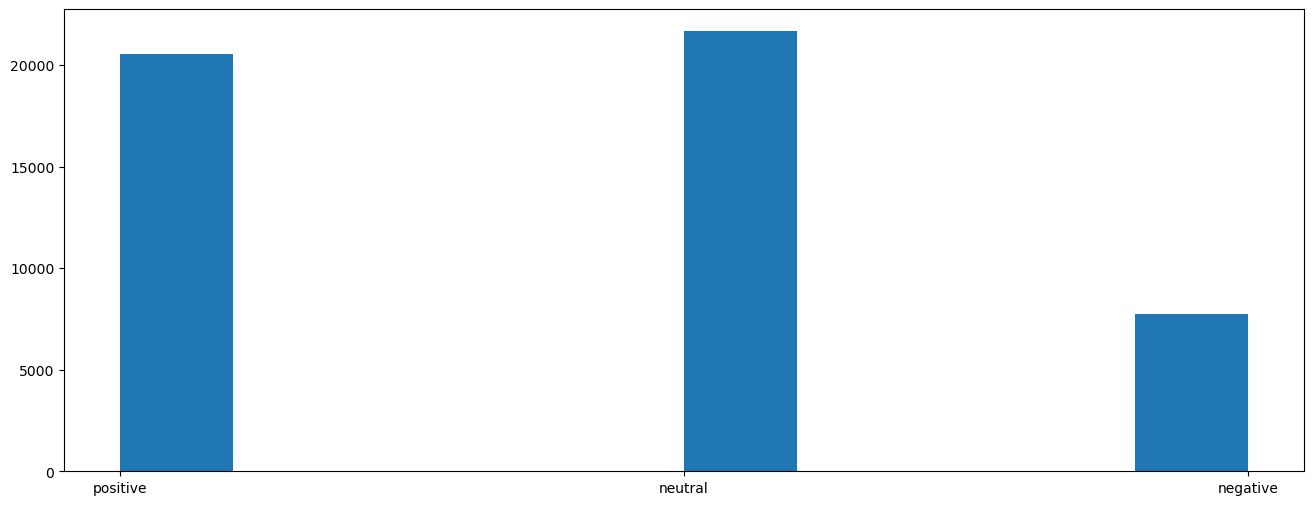

In [286]:
fakeStream.df['Sentiment'].hist(grid=False, figsize=(16,6));

C:\Users\furio\AppData\Local\Temp\ipykernel_22796\2337027304.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fakeStream.df['RollingSentiment'] = fakeStream.df.SentimentNumeric.rolling(window = wind).sum().div(wind)


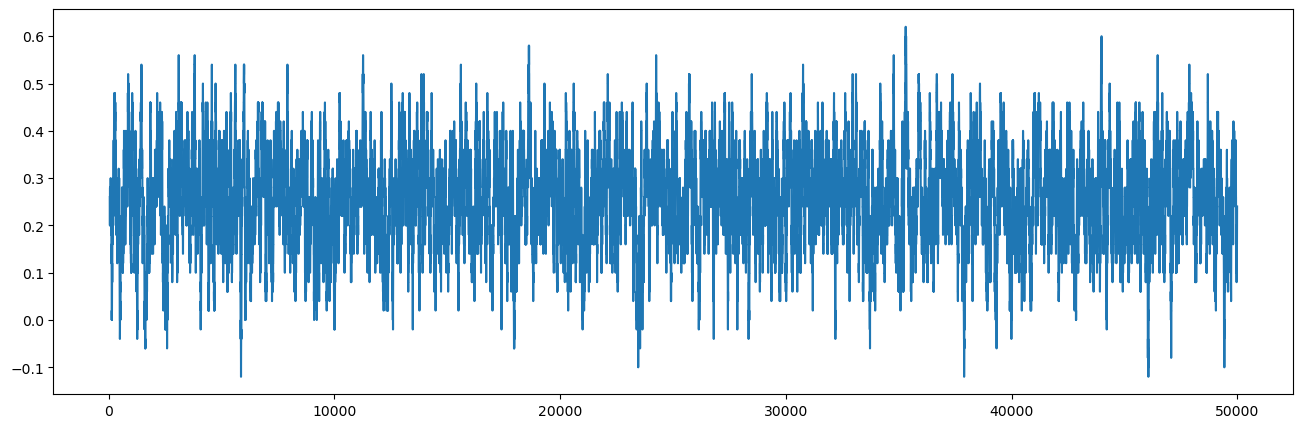

In [287]:
# Creating a rolling sentiment score
wind = 50
fakeStream.df['RollingSentiment'] = fakeStream.df.SentimentNumeric.rolling(window = wind).sum().div(wind)
fakeStream.df['RollingSentiment'].plot(figsize=(16,5));

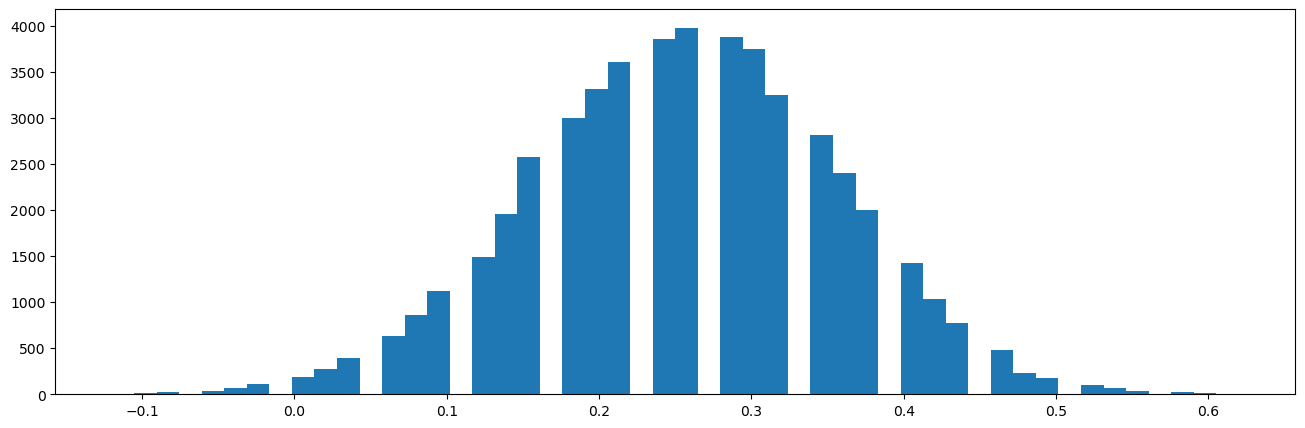

In [288]:
fakeStream.df['RollingSentiment'].hist(grid=False, figsize=(16,5), bins=50);

In [289]:
tradingBack = fakeStream.df
tradingBack['Capital'] = 1
tradingBack['Allocation'] = tradingBack.apply(lambda x: allocateCapital(x['RollingSentiment'], threshold), axis=1)

C:\Users\furio\AppData\Local\Temp\ipykernel_22796\3722923382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingBack['Capital'] = 1
C:\Users\furio\AppData\Local\Temp\ipykernel_22796\3722923382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingBack['Allocation'] = tradingBack.apply(lambda x: allocateCapital(x['RollingSentiment'], threshold), axis=1)


<AxesSubplot:>

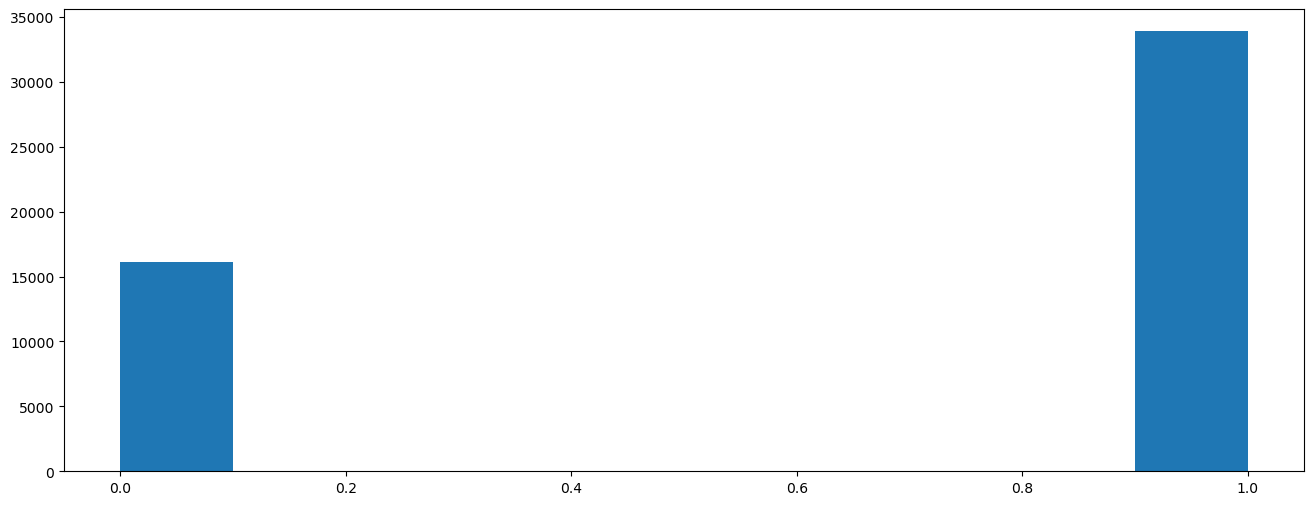

In [290]:
tradingBack['Allocation'].hist(grid=False, figsize=(16,6))

In [291]:
print("Bitcoin data needed from {} till {}".format(min(tradingBack.Time), max(tradingBack.Time)))

Bitcoin data needed from 2021-02-05 11:00:22 till 2021-08-21 12:55:53


In [292]:
btcPrice = pd.read_csv("btc_historical_price.csv")
btcPrice['date'] = pd.to_datetime(btcPrice['date'])
btcPrice

,date,price
0,2011-01-01,0.300
1,2011-01-02,0.300
2,2011-01-03,0.295
3,2011-01-04,0.299
4,2011-01-05,0.299
...,...,...
4133,2022-04-26,39971.980
4134,2022-04-27,39043.500
4135,2022-04-28,39627.555
4136,2022-04-29,39158.385


In [293]:
btcPriceSelection = btcPrice[(btcPrice.date >= min(tradingBack.Time - datetime.timedelta(days=1))) & (btcPrice.date <= max(tradingBack.Time + datetime.timedelta(days=1)))]

In [294]:
btcPriceSelection["date"] = pd.to_datetime(btcPriceSelection.date)


C:\Users\furio\AppData\Local\Temp\ipykernel_22796\255394675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcPriceSelection["date"] = pd.to_datetime(btcPriceSelection.date)


In [295]:
btcPriceSelection.set_index(btcPriceSelection.date, inplace=True)
btcPriceSelection.head()

,date,price
date,,
2021-02-05,2021-02-05,38306.2467
2021-02-06,2021-02-06,39269.3417
2021-02-07,2021-02-07,38862.3500
2021-02-08,2021-02-08,46436.0900
2021-02-09,2021-02-09,46502.2933


In [296]:
for index, row in tradingBack.iterrows():
    datum = row.Time.date()
    price = btcPriceSelection[btcPriceSelection.date.apply(lambda x: x.date()) == datum].price.values[0]
    tradingBack.loc[index, 'BitcoinPrice'] = price


c:\Python\Python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [180]:
## def findPriceAtDay(day):
##     day = day.date()
##     price = int
##     price = btcPriceSelection[btcPriceSelection.date.apply(lambda x: x.date()) == day].price.values[0]
##     ## for bi, br in btcPriceSelection.iterrows():
##     ##     btcDatum = btcPriceSelection.loc[bi, 'date'].date()
##     ##     res = (btcDatum - day).days
##     ##     if res < 1:
##     ##         price = btcPriceSelection.loc[bi, 'price']
##     ##         break
##     return price

In [218]:
## tradingBack['BitcoinPrice'] = pd.Series(list(findPriceAtDay(day) for day in tradingBack.Time.to_list()))

C:\Users\furio\AppData\Local\Temp\ipykernel_22796\1442142328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tradingBack['BitcoinPrice'] = pd.Series(list(findPriceAtDay(day) for day in tradingBack.Time.to_list()))


In [297]:
tradingBack.set_index(tradingBack.Time, inplace=True)

In [298]:
tradingBack = tradingBack[~tradingBack.index.duplicated(keep='first')]

In [299]:
tradingBack.sort_index(inplace=True)

c:\Python\Python39\lib\site-packages\pandas\core\frame.py:5579: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().sort_index(


In [300]:
for index, raw in tradingBack.iterrows():
    numIndex = tradingBack.index.get_loc(index)
    datum = row.Time.date()
    btcSelectorT0 = btcPriceSelection.date.apply(lambda x: x.date()) == datum
    btcSelectorT_1 = btcPriceSelection.date.apply(lambda x: x.date()) == datum - datetime.timedelta(days=1)
    quoteT0 = btcPriceSelection[btcSelectorT0].price.values[0] # price at time t0
    # btcIndex = btcPriceSelection.index[btcPriceSelection[btcSelector]].tolist()[0]
    quoteT_1 = btcPriceSelection[btcSelectorT_1].price.values[0] # price at time t-1
    if numIndex > 0:
        allocation = tradingBack.iloc[numIndex - 1, 10]    # allocation at time t-1, given prediction at time t-1
        capitalT_1 = tradingBack.iloc[numIndex - 1, 9]     # capital at time t-1
        # quoteT0 = raw.BitcoinPrice                         
        # quoteT_1 = tradingBack.iloc[numIndex - 1, 6]       # price at time t-1
        capital_T_1 = raw.Capital
        tradingBack.iloc[numIndex, 9] = updatePortfolio(capitalT_1=capital_T_1, quoteT_1=quoteT_1, quoteT0=quoteT0, allocation=allocation)

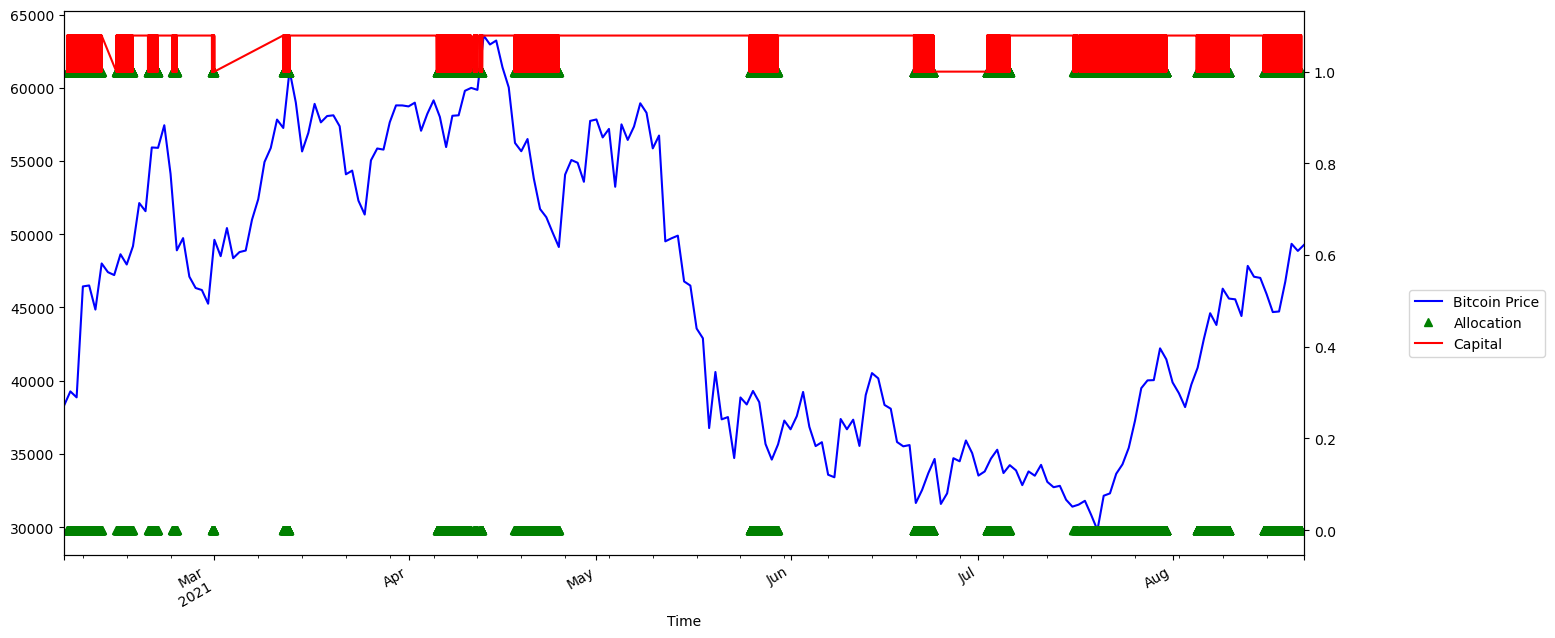

In [301]:
fig, ax = plt.subplots(figsize=(16, 8))

# tradingBack.BitcoinPrice.plot(ax=ax, style='b-')
btcPriceSelection.price.plot(ax=ax, style = 'b-')
# same ax as above since it's automatically added on the right
tradingBack.Allocation.plot(ax=ax, style='g^', secondary_y=True)
tradingBack.Capital.plot(ax=ax, style='r-', secondary_y=True)
# tradingBack.RollingSentiment.plot(ax=ax, style='y-', secondary_y=True)

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis
# ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax.right_ax.get_lines()[1], ax.right_ax.get_lines()[2]],
# ['Bitcoin Price','Allocation', 'Capital', 'Rolling Sentiment'], bbox_to_anchor=(1.2, 0.5));
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax.right_ax.get_lines()[1]],
['Bitcoin Price','Allocation', 'Capital'], bbox_to_anchor=(1.2, 0.5));

In [302]:
periodStart = datetime.datetime(year=2021, month=7, day=15)
periodEnd = datetime.datetime(year=2021, month=8, day=1)
tradingZoom = tradingBack[(tradingBack.Time > periodStart) & (tradingBack.Time < periodEnd)]

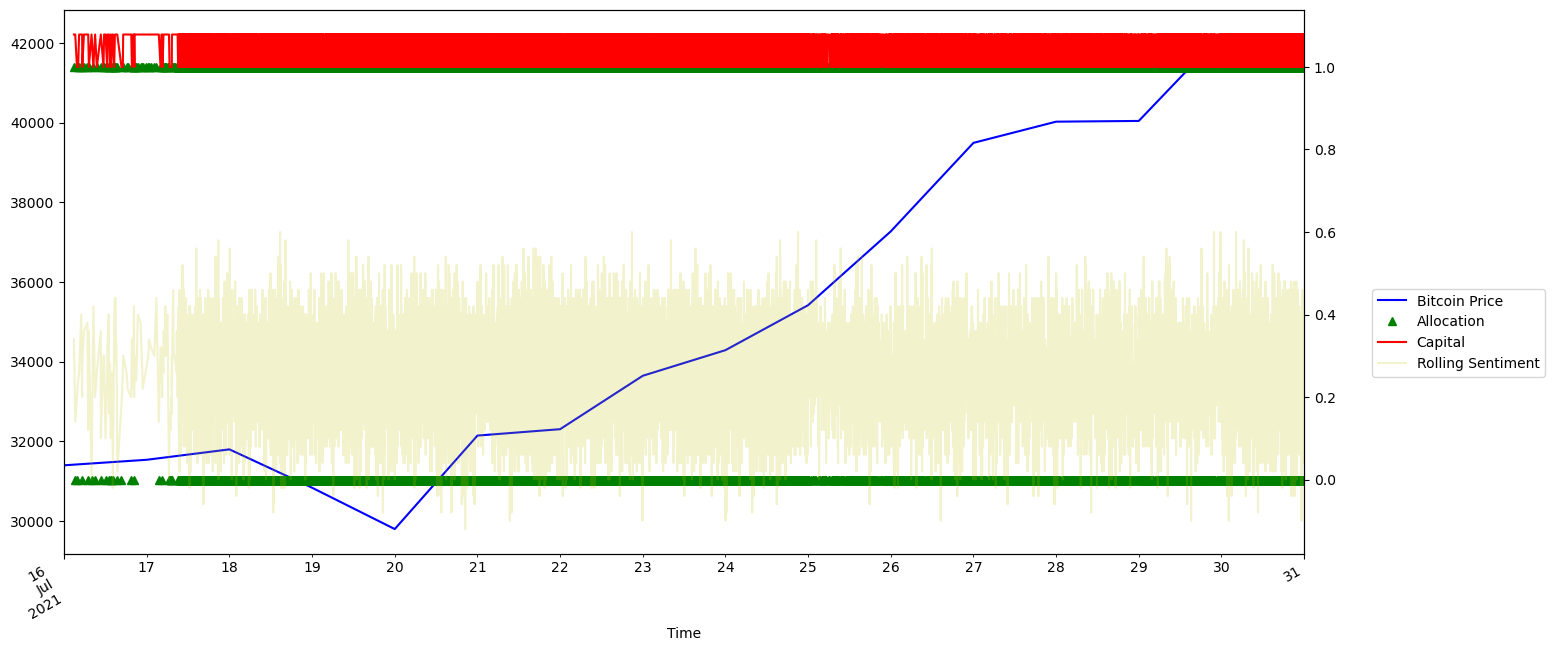

In [304]:
fig, ax = plt.subplots(figsize=(16, 8))

# tradingBack.BitcoinPrice.plot(ax=ax, style='b-')
btcPriceSelection[(btcPriceSelection.date > periodStart) & (btcPriceSelection.date < periodEnd)].price.plot(ax=ax, style = 'b-')
# same ax as above since it's automatically added on the right
tradingZoom.Allocation.plot(ax=ax, style='g^', secondary_y=True)
tradingZoom.Capital.plot(ax=ax, style='r-', secondary_y=True)
tradingZoom.RollingSentiment.plot(ax=ax, style='y-', secondary_y=True, alpha = 0.2)

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0], ax.right_ax.get_lines()[1], ax.right_ax.get_lines()[2]],
['Bitcoin Price','Allocation', 'Capital', 'Rolling Sentiment'], bbox_to_anchor=(1.2, 0.5));

## 8.1 Rolling Window based on the date
### NOT COMPLETE
since the data of the tweets and the bitcoin quotes have different frequency, the backtest need to be recalibrated with a differente score and a different allocation strategy 

In [326]:
testInd = 873
dates = [x.date() for x in tradingZoom.Time if x.date() not in dates]

In [331]:
delta = periodEnd - periodStart   # returns timedelta
dates = []
for i in range(delta.days + 1):
    day = periodStart + datetime.timedelta(days=i)
    dates.append(day)

In [349]:
for d in dates:
    selector = [x.date() ==  d - datetime.timedelta(days=1) for x in tradingZoom.Time.to_list()]
    subset = tradingZoom[selector]
    print(subset.shape[0])
    print (d)

0
2021-07-15 00:00:00
0
2021-07-16 00:00:00
0
2021-07-17 00:00:00
0
2021-07-18 00:00:00
0
2021-07-19 00:00:00
0
2021-07-20 00:00:00
0
2021-07-21 00:00:00
0
2021-07-22 00:00:00
0
2021-07-23 00:00:00
0
2021-07-24 00:00:00
0
2021-07-25 00:00:00
0
2021-07-26 00:00:00
0
2021-07-27 00:00:00
0
2021-07-28 00:00:00
0
2021-07-29 00:00:00
0
2021-07-30 00:00:00
0
2021-07-31 00:00:00
0
2021-08-01 00:00:00


In [347]:
selector.count(False)

18416

In [341]:
[x.date() ==  d - datetime.timedelta(days=1) for x in tradingZoom.Time.to_list()]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [338]:
subset

,index,id,Sentence,Time,CleanedSentence,Sentiment,BitcoinPrice,SentimentNumeric,RollingSentiment,Capital,Allocation
Time,,,,,,,,,,,


# 9. Conclusions

The exercise shows a possible way to develop a trading strategy on one asset class based on the sentiment interpreted by live tweets. </br>
There are some caveats and possible area of research for future works:</br>
1. The tweepy library combined with a free developer tweeter account gives access only to limited information
2. The classifier is based on a very limited number of tweets. The dictionary is limited and many words are not considered in the embedding
3. The data cleaning can be refined: typical expressions like RE for Retweets can be easily filtered, they don't bring anything to the classifier
4. Different languages are not considered: tweets not in english language are classified as neutral
5. Trading strategy has not been optimised: different thresholds, capital allocations, rolling windows for score can result with much better performances
---
The exercise showed that the hypothesis is viable: it is possible to define a trading strategy for high-frequency trading based on sentiment analysis on one or more specific asset classes.
Even with a modest infrastructure it is possible to have useful predictions and create an edge (and maybe even alpha!) 
